In [1]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### Data Input

In [3]:
# Input dari pengguna untuk simbol saham
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2023, 12, 1)
end_date = date(2024, 2, 1)

# Mengunduh data saham dari Yahoo Finance
data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-01,5275.0,5375.0,5275.0,5350.0,5077.938965,99499500
2023-12-04,5450.0,5575.0,5450.0,5500.0,5220.311523,235595700
2023-12-05,5425.0,5500.0,5425.0,5450.0,5172.854004,114689900
2023-12-06,5425.0,5450.0,5400.0,5425.0,5149.125000,119716700
2023-12-07,5400.0,5475.0,5400.0,5475.0,5196.582520,102126600


In [5]:
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Input feature yang akan digunakan (e.g: Open,High,Low,Close,Adj Close,Volume): ")

# Memilih kolom tanggal dan fitur yang akan digunakan
data = data[["Date", input_feat]]
print(data.shape)
print(data)

(41, 2)
         Date   Close
0  2023-12-01  5350.0
1  2023-12-04  5500.0
2  2023-12-05  5450.0
3  2023-12-06  5425.0
4  2023-12-07  5475.0
5  2023-12-08  5375.0
6  2023-12-11  5300.0
7  2023-12-12  5325.0
8  2023-12-13  5300.0
9  2023-12-14  5550.0
10 2023-12-15  5550.0
11 2023-12-18  5500.0
12 2023-12-19  5550.0
13 2023-12-20  5550.0
14 2023-12-21  5575.0
15 2023-12-22  5675.0
16 2023-12-27  5625.0
17 2023-12-28  5725.0
18 2023-12-29  5725.0
19 2024-01-02  5675.0
20 2024-01-03  5600.0
21 2024-01-04  5700.0
22 2024-01-05  5750.0
23 2024-01-08  5625.0
24 2024-01-09  5700.0
25 2024-01-10  5700.0
26 2024-01-11  5750.0
27 2024-01-12  5850.0
28 2024-01-15  5825.0
29 2024-01-16  5825.0
30 2024-01-17  5775.0
31 2024-01-18  5750.0
32 2024-01-19  5800.0
33 2024-01-22  5775.0
34 2024-01-23  5700.0
35 2024-01-24  5650.0
36 2024-01-25  5525.0
37 2024-01-26  5425.0
38 2024-01-29  5575.0
39 2024-01-30  5625.0
40 2024-01-31  5700.0


In [6]:
# Melakukan penskalaan fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

print(scaled_data)
print(dir(scaled_data))

[[0.09090909]
 [0.36363636]
 [0.27272727]
 [0.22727273]
 [0.31818182]
 [0.13636364]
 [0.        ]
 [0.04545455]
 [0.        ]
 [0.45454545]
 [0.45454545]
 [0.36363636]
 [0.45454545]
 [0.45454545]
 [0.5       ]
 [0.68181818]
 [0.59090909]
 [0.77272727]
 [0.77272727]
 [0.68181818]
 [0.54545455]
 [0.72727273]
 [0.81818182]
 [0.59090909]
 [0.72727273]
 [0.72727273]
 [0.81818182]
 [1.        ]
 [0.95454545]
 [0.95454545]
 [0.86363636]
 [0.81818182]
 [0.90909091]
 [0.86363636]
 [0.72727273]
 [0.63636364]
 [0.40909091]
 [0.22727273]
 [0.5       ]
 [0.59090909]
 [0.72727273]]
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', 

In [7]:
# Pembagian data menjadi data latih dan data uji
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]


print(train_data)
print(train_data.shape)
print(dir(train_data))

[[0.09090909]
 [0.36363636]
 [0.27272727]
 [0.22727273]
 [0.31818182]
 [0.13636364]
 [0.        ]
 [0.04545455]
 [0.        ]
 [0.45454545]
 [0.45454545]
 [0.36363636]
 [0.45454545]
 [0.45454545]
 [0.5       ]
 [0.68181818]
 [0.59090909]
 [0.77272727]
 [0.77272727]
 [0.68181818]
 [0.54545455]
 [0.72727273]
 [0.81818182]
 [0.59090909]
 [0.72727273]
 [0.72727273]
 [0.81818182]
 [1.        ]
 [0.95454545]
 [0.95454545]
 [0.86363636]
 [0.81818182]]
(32, 1)
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__'

In [8]:
# Persiapan data untuk model LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

sequence_length = 10  # Anda dapat mengubah panjangnya sesuai kebutuhan
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

input_dim_size = 10000  # Contoh: Anda membatasi kosakata hingga 10.000 kata paling umum.
embedding_dim_size = 100  # Contoh: Gunakan embedding dengan dimensi 100.


In [9]:
# Membangun model LSTM
# model = Sequential()
# model.add(Embedding(input_dim=input_dim_size, output_dim=embedding_dim_size, input_length=sequence_length))
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units=1, activation='relu'))
# model.summary()

# Membangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=input_dim_size, output_dim=embedding_dim_size, input_length=sequence_length))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 10, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,166,721
Trainable params: 1,166,721
Non-

In [10]:
# Kompilasi dan pelatihan model
cp3 = ModelCheckpoint('../model/model3/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[cp3, early_stopping], validation_data=(X_test, y_test))

Epoch 1/100
1/1 - 7s - loss: 0.5024 - mean_absolute_error: 0.6867 - 7s/epoch - 7s/step
Epoch 2/100
1/1 - 0s - loss: 0.4167 - mean_absolute_error: 0.6216 - 55ms/epoch - 55ms/step
Epoch 3/100
1/1 - 0s - loss: 0.3227 - mean_absolute_error: 0.5390 - 52ms/epoch - 52ms/step
Epoch 4/100
1/1 - 0s - loss: 0.2371 - mean_absolute_error: 0.4525 - 56ms/epoch - 56ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1437 - mean_absolute_error: 0.3370 - 63ms/epoch - 63ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0740 - mean_absolute_error: 0.2220 - 64ms/epoch - 64ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0362 - mean_absolute_error: 0.1628 - 55ms/epoch - 55ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0988 - mean_absolute_error: 0.2666 - 47ms/epoch - 47ms/step
Epoch 9/100
1/1 - 0s - loss: 0.1295 - mean_absolute_error: 0.3184 - 56ms/epoch - 56ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0966 - mean_absolute_error: 0.2489 - 59ms/epoch - 59ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0685 - mean_absolute_error: 0.2103 - 54ms/epoch - 54ms/step
E

KeyError: 'val_loss'

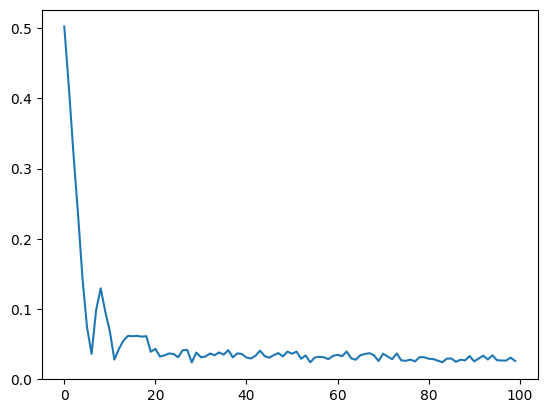

In [11]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot metrik lainnya (jika ada)
# Misalnya, jika Anda memiliki metrik akurasi:
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print("Loss di data uji:", loss)

print("Loss di data uji:", loss)
predict = model.predict(X_test)
# print(predict)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:993: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

In [ ]:
print("-"*50, " Metric ","-"*50)
print('RMSE : ',sqrt(metrics.mean_squared_error(y_test,predict)))
print('MSE  :  ',metrics.mean_squared_error(y_test,predict))
print('MAE  :  ',metrics.mean_absolute_error(y_test,predict))
print("-"*26, " Mengecek Apakah Nilainya Overfit atau tidak ","-"*26)


In [ ]:
# Simpan model
# import time

# ts = int(time.time())
# file_path = f"./lstm_stock/{ts}/"
# model.save(filepath=file_path, save_format='tf')
# model.save("../home-page-stock-prediction/lstm_model3.keras")
# print("Sucess saving model!)